In [ ]:
from pathlib import Path
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sympy
import os, shutil

In [ ]:
# Paths for SDPA-GMP execution and I/O directories
home = Path.home()
sdpa_exec = home / "sdpa-gmp" / "sdpa_gmp"
inputs = home / "sdpa-notebooks" / "inputs"
outputs = home / "sdpa-notebooks" / "outputs"
param_file_path = home / "sdpa-notebooks" / "param.sdpa"

In [ ]:
def clear_folders():
    """
    Remove all files and subdirectories inside the input and output folders.
    """

    # Iterate over folders to be cleared
    for folder in [inputs, outputs]:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)

            # Delete files or symbolic links
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)

            # Delete subdirectories recursively
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

In [ ]:
def moment_list_generator(energy, x_2, g, no_of_terms):
    """
    Generate the moment list for given parameters using the recurrence relation.

    Parameters
    ----------
    energy : float
        Energy value in the recurrence.
    x_2 : float
        Second moment value.
    g : float
        Coupling constant in the recurrence.
    no_of_terms : int
        Number of moments to generate.

    Returns
    -------
    list
        List of computed moments.
    """

    # Initial four moments
    moment_list = [1, 0, x_2, 0]

    # Recurrence for higher-order moments
    for i in range(4, no_of_terms):
        new_element = 0
        new_element += 4 * (i - 3) * energy * moment_list[i - 4]
        new_element += (i - 3) * (i - 4) * (i - 5) * moment_list[i - 6]
        new_element -= 2 * (2 * i - 4) * moment_list[i - 2]
        new_element /= 2 * g * (2 * i - 2)

        moment_list.append(new_element)

    return moment_list


In [ ]:
def Hankel_matrix_generator(moment_list: list, K: int):
    """
    Construct a K * K Hankel matrix from a list of moments.

    Parameters
    ----------
    moment_list : list
        List of moments x_0, x_1, ..., used to fill the Hankel matrix.
        Assumes length >= 2K - 1.
    K : int
        Dimension of the (square) Hankel matrix.

    Returns
    -------
    matrix : list of lists
        A K * K Hankel matrix where M[i][j] = moment_list[i + j].
    """

    matrix = []

    for i in range(K):
        row = []
        for j in range(K):
            row.append(moment_list[i + j])
        matrix.append(row)

    return matrix

In [ ]:
def extract_obj_val(result, file_path):
    """
    Extract the primal objective value ('objValPrimal') from an SDPA output file.

    Parameters
    ----------
    result : CompletedProcess
        The subprocess result returned by running SDPA.
    file_path : str
        Path to the SDPA output file to read.

    Returns
    -------
    float
        The extracted primal objective value.

    Raises
    ------
    ValueError
        If 'objValPrimal' is not found in the file.
    """

    # Look for the line containing 'objValPrimal'
    with open(file_path, 'r') as f:
        for line in f:
            if 'objValPrimal' in line:
                # Extract the numeric value at the end of the line
                return float(line.strip().split()[-1])

    # If not found, print solver output for debugging
    print(result.stdout)
    raise ValueError("objValPrimal not found in output file.")

In [ ]:
# Parameter grids for K, energy, and x₂
K_list = [8, 9, 10, 11, 12]
energy_list = list(np.arange(1.35, 1.45, 0.001))
x_2_list = list(np.arange(0.29, 0.315, 0.0001))
g = 1

# Store log10(|t|) values for each K
t_val_dict = {}

for K in K_list:
    t_val_list = []

    for x_2 in x_2_list:
        temp = []   # Stores values across all energies for this x₂

        for energy in energy_list:
            # Generate moments and build Hankel matrix
            moment_list = moment_list_generator(energy, x_2, g, 2 * K + 1)
            matrix = Hankel_matrix_generator(moment_list, K)

            # Build SDPA input content
            input_content = "1"
            input_content += "\n1"
            input_content += f"\n{K}"
            input_content += "\n-1"

            # Add upper‐triangular entries
            for i in range(K):
                for j in range(i, K):
                    if matrix[i][j] != 0:
                        input_content += f"\n0 1 {i + 1} {j + 1} {-matrix[i][j]}"

            # Add identity constraint
            for i in range(K):
                input_content += f"\n1 1 {i + 1} {i + 1} -1"

            # File paths
            input_file = str(inputs) + f"/data_{K}_{energy}_{x_2}.dat-s"
            output_file = str(outputs) + f"/result_{K}_{energy}_{x_2}.out"

            # Write SDPA input
            Path(input_file).write_text(input_content)

            # Run SDPA-GMP
            result = subprocess.run(
                [str(sdpa_exec), str(input_file), str(output_file)],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True,
                check=True
            )

            # Read objective value
            primal_val = extract_obj_val(result, output_file)
            temp.append(np.log10(np.abs(primal_val)))

        t_val_list.append(temp)

    # Store data for this K
    t_val_dict[K] = t_val_list


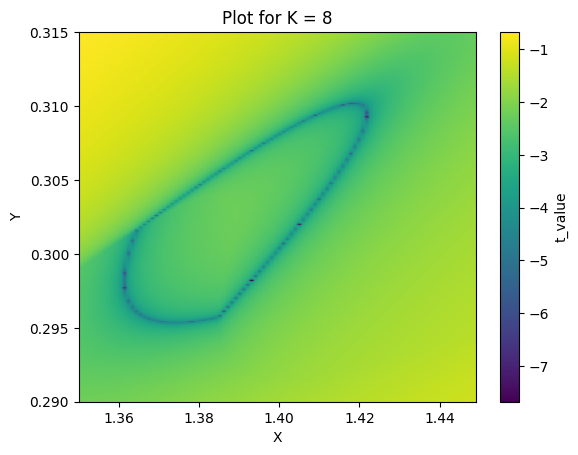

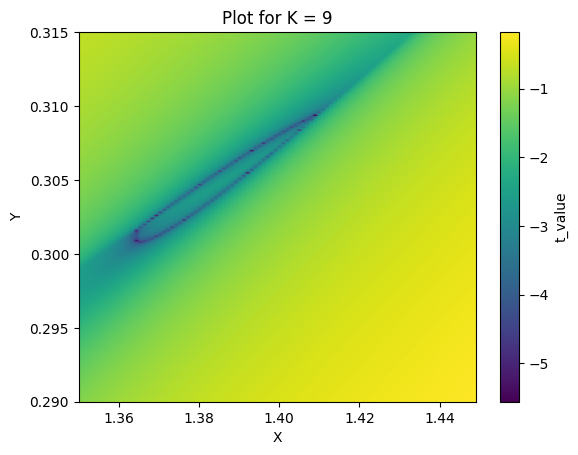

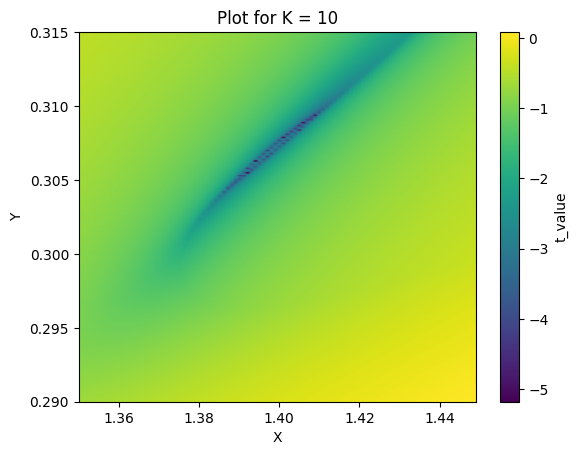

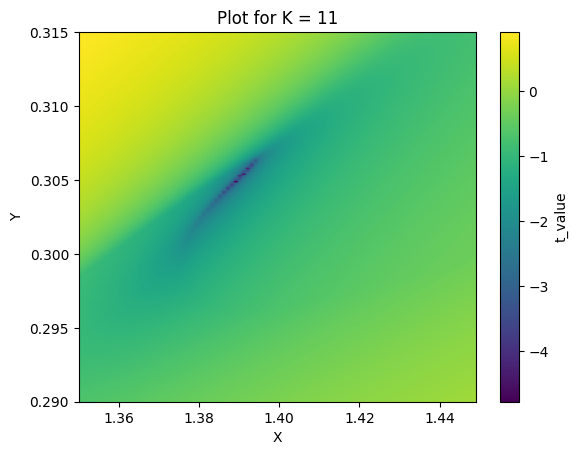

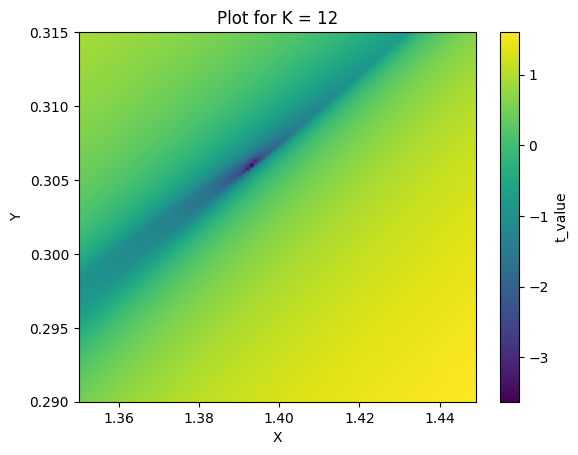

In [ ]:
for K in K_list:
    plt.figure()

    # Heatmap of log10(|t|) over (energy, x₂)
    plt.imshow(
        t_val_dict[K],
        extent=[min(energy_list), max(energy_list),
                min(x_2_list), max(x_2_list)],
        origin='lower',
        cmap='viridis',
        aspect='auto'
    )

    plt.colorbar(label='t_value')
    plt.title(f"Plot for K = {K}")

    # Axis labels
    plt.xlabel("Energy")
    plt.ylabel("x_2")

    plt.show()
